# 神经网络的通用近似定理（Universal Approximation Theorem）
## numpy实现
>对于任何连续函数f: Rⁿ → R 和任意ε > 0  
存在一个包含单隐藏层的前馈神经网络，其输出与f的误差不超过ε  
ReLU的线性区段组合可以形成分段线性近似

**在本题中，通过组合多个ReLU激活的线性变换，网络可以构建足够多的"折线段"来逼近x²曲线。随着隐藏层神经元数量的增加，近似精度会不断提高。**  
选择的目标函数是x²，属于典型的非线性函数，可以很好地测试网络的拟合能力。

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

## 目标拟合函数(y = x^2)

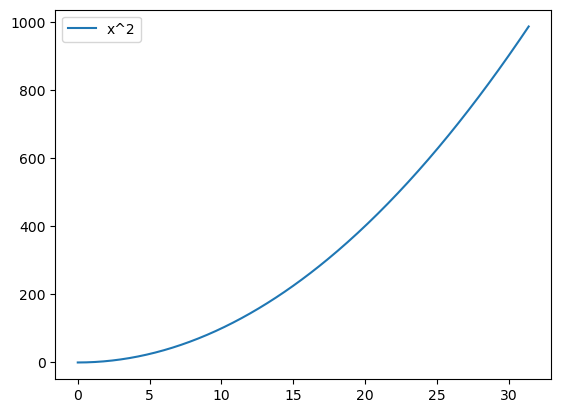

In [6]:
# 与PyTorch版本相同
def targetFunc(x):
    """目标函数：x²的平方函数"""
    return x * x

x = np.arange(0, 10 * np.pi, 0.1)
plt.plot(x, [targetFunc(i) for i in x])
plt.legend(["x^2"])

x = np.arange(0, 5 * np.pi, 0.001)
y = [targetFunc(i) for i in x]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1)

In [7]:
# 模型参数初始化
input_dim = 1    # 输入维度（标量）
hidden_dim = 16  # 隐藏层神经元数量
output_dim = 1   # 输出维度（标量）

# Xavier初始化（保持方差一致性）
W1 = np.random.randn(hidden_dim, input_dim) * np.sqrt(1 / input_dim)   # 输入层到隐藏层权重
W2 = np.random.randn(output_dim, hidden_dim) * np.sqrt(1 / hidden_dim) # 隐藏层到输出层权重
b1 = np.zeros((hidden_dim, 1))  # 隐藏层偏置
b2 = np.zeros((output_dim, 1))  # 输出层偏置

In [8]:
cache = {}

def Linear(W, X, b):
    """线性变换"""
    return np.matmul(W, X) + b


def relu(X):
    """ReLU 激活函数"""
    return np.where(X > 0, X, 0)

# 前向传播函数
def forward(x):
    """手动实现前向传播流程"""
    cache['out0'] = x      # 存储输入值用于反向传播
    x = Linear(W1, x, b1)  # 第一层线性变换：W1*x + b1
    cache['out1'] = x      # 存储线性变换结果
    x = relu(x)            # ReLU激活
    cache['out2'] = x      # 存储激活结果
    output = Linear(W2, x, b2)  # 第二层线性变换
    cache['out3'] = output # 存储最终输出
    return output

# 损失函数计算
def loss_fn(y_pred, target):
    """手动实现MSE损失计算"""
    loss = np.sum((y_pred - target)**2, axis=1, keepdims=True) / len(y_pred)
    cache['loss'] = 2 * (y_pred - target) / len(y_pred) # 存储梯度信息
    return loss

# 反向传播实现
def backward(lr, batch_size):
    """手动实现反向传播（链式法则）"""
    global W1, W2, b1, b2

    # 输出层梯度计算
    delta2 = 1 / batch_size * cache['loss']   # ∂L/∂y_pred = 2(y_pred - y)/N
    dW2 = 1 / batch_size * np.matmul(delta2, cache['out2'].T)  # ∂L/∂W2 = delta2 * a1.T
    db2 = 1 / batch_size * np.sum(delta2, axis=1, keepdims=True)  # ∂L/∂b2 = sum(delta2)

    # 隐藏层梯度计算
    delta1 = np.matmul(W2.T, delta2) * np.where(cache['out1'] > 0, 1, 0)  # ∂L/∂a1 = W2.T * delta2 ⊙ relu'
    dW1 = 1 / batch_size * np.matmul(delta1, cache['out0'].T)    # ∂L/∂W1 = delta1 * x.T
    db1 = 1 / batch_size * np.sum(delta1, axis=1, keepdims=True) # ∂L/∂b1 = sum(delta1)

    # 参数更新（梯度下降）
    W1 -= lr * dW1
    W2 -= lr * dW2
    b1 -= lr * db1
    b2 -= lr * db2

In [9]:
def predict(ranger):
    """评估函数"""
    x_plot = []
    y_pred = []
    for i in range(ranger[0], ranger[1]):
        x = Linear(W1, np.array([[i]]), b1)
        x = relu(x)
        output = Linear(W2, x, b2)
        x_plot.append(i)
        y_pred.extend(output)

    plt.plot(x_plot, [targetFunc(i) for i in x_plot])
    plt.plot(x_plot, y_pred)
    plt.legend(["Ground truth", "Prediction"])

In [10]:
# 训练流程
def train(X, y, epochs=5, batch_size=10, lr=0.001, verbose_ep=100):
    """手动训练循环"""
    for epoch in tqdm(range(epochs)):
        rec_loss = 0
        # 手动分批次
        for batch_idx in range(len(X) // batch_size):
            # 获取当前批次数据（需要转置为列向量）
            X_batched = np.array([X[batch_idx * batch_size: min((batch_idx + 1) * batch_size, len(X))]])
            y_batched = np.array([y[batch_idx * batch_size: min((batch_idx + 1) * batch_size, len(X))]])
            # 前向传播
            y_pred = forward(X_batched)
            # 计算损失
            loss = np.sum(loss_fn(y_pred,np.array(y_batched))) / len(y_pred)
            rec_loss += loss
            # 反向传播更新参数
            backward(lr, batch_size)
        if epoch % verbose_ep == 0:
            print(f"Epoch:{epoch}, Loss:{rec_loss / (len(X) // batch_size)}")

In [11]:
train(X_train, y_train, epochs=5000, batch_size=32, lr=0.01, verbose_ep=1000)

  0%|                                                  | 10/5000 [00:00<01:40, 49.86it/s]

Epoch:0, Loss:20793.015025093802


 20%|█████████▋                                      | 1010/5000 [00:19<01:18, 50.73it/s]

Epoch:1000, Loss:18.407843262180773


 40%|███████████████████▎                            | 2011/5000 [00:39<00:57, 52.02it/s]

Epoch:2000, Loss:11.608315042103126


 60%|████████████████████████████▉                   | 3011/5000 [00:59<00:39, 50.87it/s]

Epoch:3000, Loss:9.246719645602921


 80%|██████████████████████████████████████▍         | 4010/5000 [01:19<00:19, 49.82it/s]

Epoch:4000, Loss:8.588597550347279


100%|████████████████████████████████████████████████| 5000/5000 [01:38<00:00, 50.51it/s]


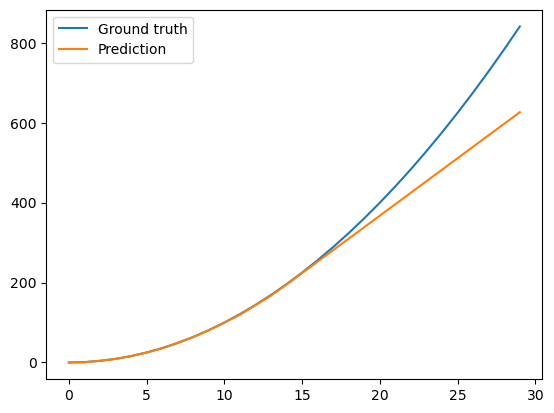

In [12]:
predict([0, 30])

这里可以看到[0-17]范围内拟合效果是很好的，想要进一步增加拟合效果需要增加神经元数量或者其他改进